In [1]:
from BigDFT import Logfiles as lf
from BigDFT import DoS as D
from futile import Yaml
from futile.Utils import write
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import LRTDDFT as LR
HaeV=27.21138386

In [2]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../

# LR Analysis

This notebook analyze the LR properties of a system. It assumes that the TDDFT-BigDFT computation has already been performed.

## Analysis of the $CO$ molecule

In [3]:
norbCO = 5
pathCO = 'CO/linear-response/'
CO = build_syst_dict(pathCO, norbCO)
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [4]:
get_tddft_quantities(CO,pathCO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/CO/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


Solve the Casida eigenproblems using naSmall virtual orbitals. In this example the choice naSmall = nvirt is performed but the actual number of virtual orbitals can be reduced to check the convergence of the results w.r.t. the 
dimension of the basis in the empty-state subspace.

In [6]:
naSmall = [280]

In [7]:
reload(LR)
LR.diagonalize_CM(norbCO,CO,naSmall)
LR.collect_LR(CO)

Solve for rVal =  9.0
Eigensystem solved for 280
Solve for rVal =  10.0
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 280


#### Dynamical polarizability

In [8]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

Compute for rVal =  9.0  with nalpha =  280
numpoint =  336  omegaMax (eV) =  45.8183849825
Compute for rVal =  10.0  with nalpha =  280
numpoint =  311  omegaMax (eV) =  42.431982253
Compute for rVal =  7.0  with nalpha =  280
numpoint =  434  omegaMax (eV) =  59.1066901023


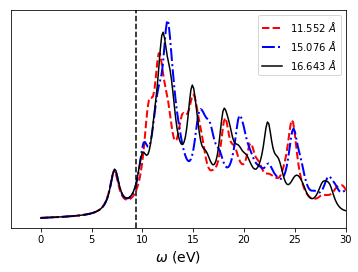

In [9]:
%matplotlib inline
syst = CO_spectrum
part = 'imagPart' #use 'realPart' to plot the real part of the dynamical polarizability
size = str(CO[7.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[7.0]['omega'],syst[7.0][part],'--',c='red',linewidth=2,label= size + ' $\AA$')
size = str(CO[9.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[9.0]['omega'],syst[9.0][part],'-.',c='blue',linewidth=2,label= size + ' $\AA$')
size = str(CO[10.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[10.0]['omega'],syst[10.0][part],'-',c='black',linewidth=1.5,label= size + ' $\AA$')
plt.xlim(xmax=30)
plt.yticks([])
plt.xlabel(r'$\omega$ (eV)',size = 14)
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.legend(loc='best')
plt.show()

### Excitation Landscape

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [63]:
th_value = 1e-4
th_levels = [1,2,3,3,4]

In [64]:
numExcCO = 2800
LR.collect_excitation_thr(CO,norbCO,numExcCO,th_levels,th_value)
CO_channels = LR.collect_channels(CO,norbCO,numExcCO,th_levels)

We plot the excitation landscape

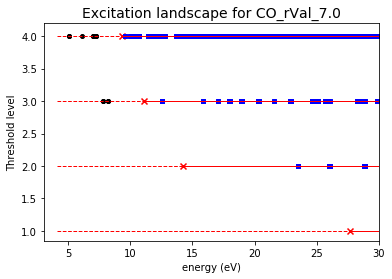

In [65]:
r = 7.0 # choice of the box size

nalpha = CO[r]['eigenproblems'].keys()
nalpha.sort()
nvirt = nalpha[-1]
syst = CO[r]['eigenproblems'][nvirt]
th_energies = HaeV*abs(LR.get_p_energy(CO[r]['logfile'],norbCO))

Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
Emax = 30

for level in CO_channels[r]:
    eng_th = th_energies[th_levels.index(level)]
    plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
    plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
    plt.scatter(eng_th,level,marker='x',c='red')
  
    for exc in CO_channels[r][level]:
        if exc[1] < eng_th: 
            plt.scatter(exc[1],level,s=16,marker='o',c='black')
        else:
            plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
plt.title('Excitation landscape for CO_rVal_'+str(r),size=14) 
plt.xlabel('energy (eV)')
plt.ylabel('Threshold level')
plt.xlim(xmin=Emin-1,xmax=Emax)
plt.show()

### Excitation DOS

We identify the excitations below and above threshold

In [66]:
reload(LR)
CO_ind_bt,CO_ind_at = LR.collect_index_bt_at(CO)

Plot the Dos below threshold

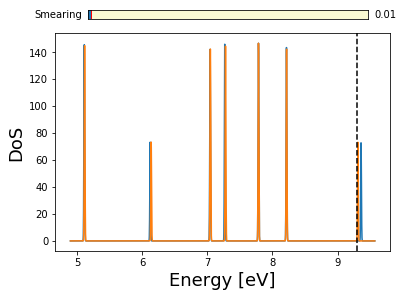

In [67]:
%matplotlib inline
dos=D.DoS(fermi_level=9.3)
for rVal in [9.0,10.0]: #CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][CO_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.0002*HaeV)

Plot the complete Dos

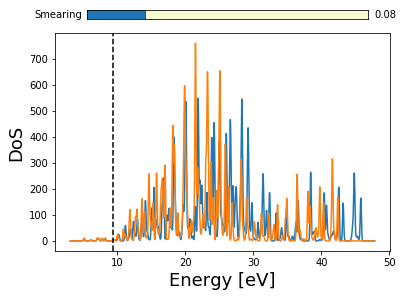

In [68]:
%matplotlib inline
dos=D.DoS(fermi_level=9.3)
for rVal in [9.0,10.0]: #CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][CO_ind_bt[rVal]+CO_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.003*HaeV)

### Statical polarizability vs. number of excitations

We plot the converge plot of the statical polarizability to its reference (finite difference) value in function
of the number of excitations.

In [106]:
CO_alpha_ref = {'alphaX':13.235,'alphaY':13.235,'alphaZ':18.728}

In [107]:
r = 7.0 # box size
nvirt = CO[r]['nvirt']
e2 = CO[r]['eigenproblems'][nvirt]['eigenvalues']
e = HaeV*np.sqrt(e2)
f = HaeV**2*np.array(CO[r]['eigenproblems'][nvirt]['oscillator_strengths'])

w_zz = []
for exc in range(numExcCO):
    w_zz.append(2.0*f[exc][2])
    
alpha_zz = [0.0 for i in range(numExcCO)]
for ind,val in enumerate(w_zz):
    if ind>0:
        alpha_zz[ind] = alpha_zz[ind-1] + val/(e[ind]**2)

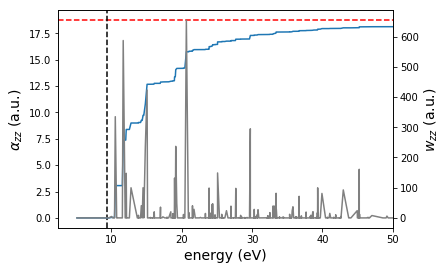

In [111]:
%matplotlib inline

fig, ax1 = plt.subplots()

ax1.set_xlabel('energy (eV)',size = 14)
plt.ylabel(r'$\alpha_{zz}$ (a.u.)',size = 14)
plt.axhline(y=CO_alpha_ref['alphaZ'], color='r', linestyle='--')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[rVal]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
ax1.plot(e,np.array(alpha_zz))

ax2 = ax1.twinx()
ax2.plot(e,w_zz,color='grey',linestyle='-')
plt.xlim(xmax=50)
plt.ylabel(r'$w_{zz}$ (a.u.)',size=14)
plt.show()

## Analysis of the Benzene molecule

In [36]:
norbC6H6 = 15
pathC6H6 = 'C6H6/linear-response/'
C6H6 = build_syst_dict(pathC6H6, norbC6H6)
C6H6

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


{7.0: {'nvirt': 220}, 9.0: {'nvirt': 220}, 10.0: {'nvirt': 220}}

In [37]:
reload(LR)
get_tddft_quantities(C6H6,pathC6H6)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper/C6H6/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/nb_paper


Solve the Casida eigenproblems using naSmall virtual orbitals. In this example the choice naSmall = nvirt is performed but the actual number of virtual orbitals can be reduced to check the convergence of the results w.r.t. the 
dimension of the basis in the empty-state subspace.

In [39]:
naSmall = [220]

In [40]:
LR.diagonalize_CM(norbC6H6,C6H6,naSmall)
LR.collect_LR(C6H6)

Solve for rVal =  9.0
Eigensystem solved for 220
Solve for rVal =  10.0
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 220


#### Dynamical polarizability

In [41]:
reload(LR)
C6H6_spectrum = LR.collect_spectrum(C6H6)

Compute for rVal =  9.0  with nalpha =  220
numpoint =  240  omegaMax (eV) =  32.740054836
Compute for rVal =  10.0  with nalpha =  220
numpoint =  228  omegaMax (eV) =  31.0830728297
Compute for rVal =  7.0  with nalpha =  220
numpoint =  280  omegaMax (eV) =  38.1274605755


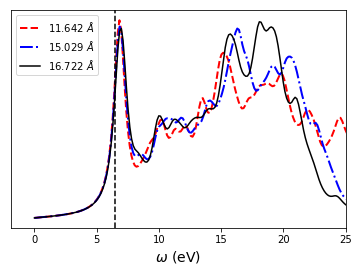

In [44]:
%matplotlib inline
syst = C6H6_spectrum
part = 'imagPart' #use 'realPart' to plot the real part of the dynamical polarizability
size = str(C6H6[7.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[7.0]['omega'],syst[7.0][part],'--',c='red',linewidth=2,label= size + ' $\AA$')
size = str(C6H6[9.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[9.0]['omega'],syst[9.0][part],'-.',c='blue',linewidth=2,label= size + ' $\AA$')
size = str(C6H6[10.0]['logfile'].log['Sizes of the simulation domain']['Angstroem'][2])
plt.plot(syst[10.0]['omega'],syst[10.0][part],'-',c='black',linewidth=1.5,label= size + ' $\AA$')
plt.xlim(xmax=25)
plt.yticks([])
plt.xlabel(r'$\omega$ (eV)',size = 14)
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.legend(loc='best')
plt.show()

### Excitation Landscape

We attribute to the first numExc excitations a threshold key ('th') that contain the value of the psi_p of highest energy that contributes to the excitation, with a threshold level given by th_value. We take into account the degenaracy of the psi_p states to build the threshold levels.  

In [112]:
th_value = 5e-2
th_levels = [1,2,2,3,3,4,5,5,6,6,7,8,8,9,9]

In [114]:
reload(LR)
numExcC6H6 = 220*15*2
LR.collect_excitation_thr(C6H6,norbC6H6,numExcC6H6,th_levels,th_value)
C6H6_channels = LR.collect_channels(C6H6,norbC6H6,numExcC6H6,th_levels)

We plot the excitations landscape

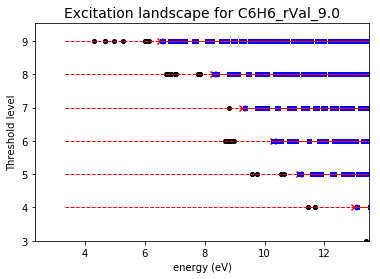

In [115]:
r = 9.0 # choice of the box size

nvirt = C6H6[r]['nvirt']
syst = C6H6[r]['eigenproblems'][nvirt]
th_energies = HaeV*abs(LR.get_p_energy(C6H6[r]['logfile'],norbC6H6))

Emin = HaeV*np.sqrt(syst['eigenvalues'][0])-1
Emax = 13.5

for level in C6H6_channels[r]:
    eng_th = th_energies[th_levels.index(level)]
    plt.plot((Emin,eng_th),(level,level),'--',c='red',linewidth=1)
    plt.plot((eng_th,Emax),(level,level),'-',c='red',linewidth=1)
    plt.scatter(eng_th,level,marker='x',c='red')
  
    for exc in C6H6_channels[r][level]:
        if exc[1] < eng_th: 
            plt.scatter(exc[1],level,s=16,marker='o',c='black')
        else:
            plt.scatter(exc[1],level,s=14,marker='s',c='blue')
                
plt.title('Excitation landscape for C6H6_rVal_'+str(r),size=14) 
plt.xlabel('energy (eV)')
plt.ylabel('Threshold level')
plt.xlim(xmin=Emin-1,xmax=Emax)
plt.ylim(ymin=3)
plt.show()

### Excitation DOS

We identify the excitations below and above threshold

In [116]:
reload(LR)
C6H6_ind_bt,C6H6_ind_at = LR.collect_index_bt_at(C6H6)

Plot the Dos below threshold

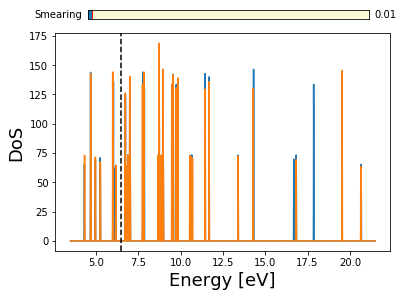

In [117]:
%matplotlib inline
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.0002*HaeV)

Plot the complete dos

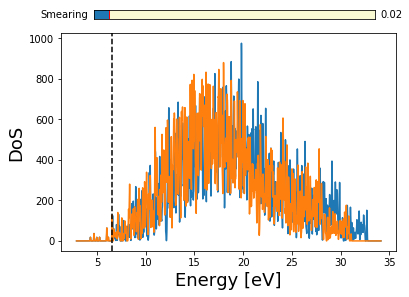

In [118]:
%matplotlib inline
dos=D.DoS(fermi_level=6.5)
for rVal in [9.0,10.0]:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]   
    eng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][C6H6_ind_bt[rVal]+C6H6_ind_at[rVal]])
    dos.append(energies=np.array([eng]),label='_rVal_'+str(rVal))
dos.plot(sigma=0.0008*HaeV)

### Statical polarizability vs. number of excitations

We plot the converge plot of the statical polarizability to its reference (finite difference) value in function
of the number of excitations.

In [119]:
C6H6_alpha_ref = {'alphaX':83.86,'alphaY':83.86,'alphaZ':45.62}

In [128]:
r = 7.0 # box size
nvirt = C6H6[r]['nvirt']
e2 = C6H6[r]['eigenproblems'][nvirt]['eigenvalues']
e = HaeV*np.sqrt(e2)
f = HaeV**2*np.array(C6H6[r]['eigenproblems'][nvirt]['oscillator_strengths'])

w_zz = []
for exc in range(numExcC6H6):
    w_zz.append(2.0*f[exc][2])
    
alpha_zz = [0.0 for i in range(numExcC6H6)]
for ind,val in enumerate(w_zz):
    if ind>0:
        alpha_zz[ind] = alpha_zz[ind-1] + val/(e[ind]**2)

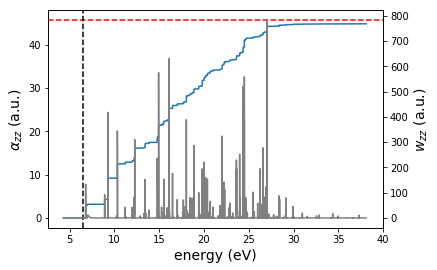

In [129]:
%matplotlib inline

fig, ax1 = plt.subplots()

ax1.set_xlabel('energy (eV)',size = 14)
plt.ylabel(r'$\alpha_{zz}$ (a.u.)',size = 14)
plt.axhline(y=C6H6_alpha_ref['alphaZ'], color='r', linestyle='--')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[rVal]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
ax1.plot(e,np.array(alpha_zz))

ax2 = ax1.twinx()
ax2.plot(e,w_zz,color='grey',linestyle='-')
plt.xlim(xmax=40)
plt.ylabel(r'$w_{zz}$ (a.u.)',size=14)
plt.show()